<a href="https://colab.research.google.com/github/Jammyeong/MachineLearningClass/blob/main/6thWeek/Tugas_6_ML_Clustering_Campaign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Impor Pustaka yang Diperlukan
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

In [18]:
# Memuat dan Membersihkan Data
df = pd.read_csv('/content/drive/MyDrive/smt akhir/ml/clusteringcampaign.csv', sep='\t')
print("Dimensi data awal:")
print(df.shape)

Dimensi data awal:
(2240, 29)


In [12]:
# # Hapus baris di mana 'Income' tidak ada, karena ini adalah fitur penting untuk analisis moneter
# df.dropna(subset=['Income'], inplace=True)
# print("Dimensi data setelah membersihkan nilai kosong:")
# print(df.shape)

Dimensi data setelah membersihkan nilai kosong:
(2216, 29)


In [19]:
# Hitung median dari kolom 'Income'
median_income = df['Income'].median()

# Isi nilai NaN dengan nilai median
df['Income'].fillna(median_income, inplace=True)

# Cek kembali untuk memastikan tidak ada lagi NaN
print(df['Income'].isnull().sum())

0


In [21]:
# Daftar kolom yang digunakan untuk membuat fitur RFM
rfm_cols = ['Recency', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
            'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
            'MntSweetProducts', 'MntGoldProds', 'ID'] # Include 'ID' for index

# Hapus baris jika ada nilai kosong di salah satu kolom RFM
df.dropna(subset=rfm_cols, inplace=True)
print("Dimensi data setelah membersihkan nilai kosong di kolom RFM:")
print(df.shape)

Dimensi data setelah membersihkan nilai kosong di kolom RFM:
(2240, 29)


In [22]:
# Siapkan kolom-kolom yang akan dihitung
monetary_cols = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
frequency_cols = ['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']

# Buat DataFrame RFM dalam satu langkah, langsung dengan data dan index yang benar
df_rfm = pd.DataFrame({
    'Recency': df['Recency'].values,
    'Frequency': df[frequency_cols].sum(axis=1).values,
    'MonetaryValue': df[monetary_cols].sum(axis=1).values
}, index=df['ID'])

# Tampilkan 5 baris pertama untuk memastikan hasilnya benar
print("Contoh data RFM sebelum transformasi:")
print(df_rfm.head())

Contoh data RFM sebelum transformasi:
      Recency  Frequency  MonetaryValue
ID                                     
5524       58         22           1617
2174       38          4             27
4141       26         20            776
6182       26          6             53
5324       94         14            422


In [23]:
# Transformasi dan Penskalaan Data
# Menggunakan log1p untuk mengatasi data yang skewed dan menghindari error jika ada nilai 0
df_rfm_log = np.log1p(df_rfm)

# Standarisasi data agar setiap fitur memiliki skala yang sama (mean=0, std=1)
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(df_rfm_log)
rfm_scaled = pd.DataFrame(rfm_scaled, index=df_rfm.index, columns=df_rfm.columns)

print("Contoh data RFM setelah penskalaan:")
print(rfm_scaled.head())

Contoh data RFM setelah penskalaan:
       Recency  Frequency  MonetaryValue
ID                                      
5524  0.483779   1.139021       1.202909
2174  0.049887  -1.349737      -1.556432
4141 -0.335530   0.990660       0.703988
6182 -0.335530  -0.801003      -1.109700
5324  0.983035   0.441927       0.290388


In [24]:
# --- Membuat dan Mengevaluasi Model K-Means ---
inertia = []
silhouette = []
calinski = []
davies = []
K = range(2, 11) # Menentukan rentang jumlah cluster yang akan diuji (2 hingga 10)

for k in K:
    # Inisialisasi dan latih model K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)

    # Simpan metrik evaluasi
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(rfm_scaled, kmeans.labels_))
    calinski.append(calinski_harabasz_score(rfm_scaled, kmeans.labels_))
    davies.append(davies_bouldin_score(rfm_scaled, kmeans.labels_))

In [25]:
# --- Menampilkan Hasil Clustering K-Means ---
# Pilih jumlah cluster terbaik berdasarkan analisis metrik (misal k=4, perlu disesuaikan berdasarkan plot)
final_k_kmeans = 4

# Buat dan latih model K-Means final
kmeans_final = KMeans(n_clusters=final_k_kmeans, random_state=42, n_init=10)
kmeans_final.fit(rfm_scaled)

# Tambahkan kolom 'Cluster' ke dataframe RFM asli untuk melihat hasilnya
df_rfm['KMeans_Cluster'] = kmeans_final.labels_

print("HASIL AKHIR CLUSTERING (K-Means dengan k=4)")
print("\nJumlah Pelanggan per Cluster:")
print(df_rfm['KMeans_Cluster'].value_counts().sort_index())

HASIL AKHIR CLUSTERING (K-Means dengan k=4)

Jumlah Pelanggan per Cluster:
KMeans_Cluster
0    1038
1     205
2     269
3     728
Name: count, dtype: int64


In [26]:
# --- Membuat dan Mengevaluasi Model Agglomerative Clustering ---
silhouette_agg = []
calinski_agg = []
davies_agg = []

for k in K:
    # Inisialisasi dan latih model Agglomerative Clustering
    agg_cluster = AgglomerativeClustering(n_clusters=k)
    labels = agg_cluster.fit_predict(rfm_scaled)

    # Simpan metrik evaluasi
    silhouette_agg.append(silhouette_score(rfm_scaled, labels))
    calinski_agg.append(calinski_harabasz_score(rfm_scaled, labels))
    davies_agg.append(davies_bouldin_score(rfm_scaled, labels))

In [28]:
# --- Menerapkan Model Final Agglomerative Clustering dan Menampilkan Hasil ---
# Berdasarkan analisis metrik, pilih k terbaik (misal k=3, perlu disesuaikan berdasarkan plot)
final_k_agg = 3

# Buat model final dengan cluster yang dipilih
agg_final = AgglomerativeClustering(n_clusters=final_k_agg)

# Latih model dan dapatkan label cluster untuk setiap pelanggan
final_labels_agg = agg_final.fit_predict(rfm_scaled)

# Tambahkan kolom 'Cluster' ke dataframe RFM asli
df_rfm['Agg_Cluster'] = final_labels_agg

print("HASIL AKHIR CLUSTERING (Agglomerative dengan k=3)")
print("\nJumlah Pelanggan per Cluster:")
print(df_rfm['Agg_Cluster'].value_counts().sort_index())

HASIL AKHIR CLUSTERING (Agglomerative dengan k=3)

Jumlah Pelanggan per Cluster:
Agg_Cluster
0     811
1    1280
2     149
Name: count, dtype: int64


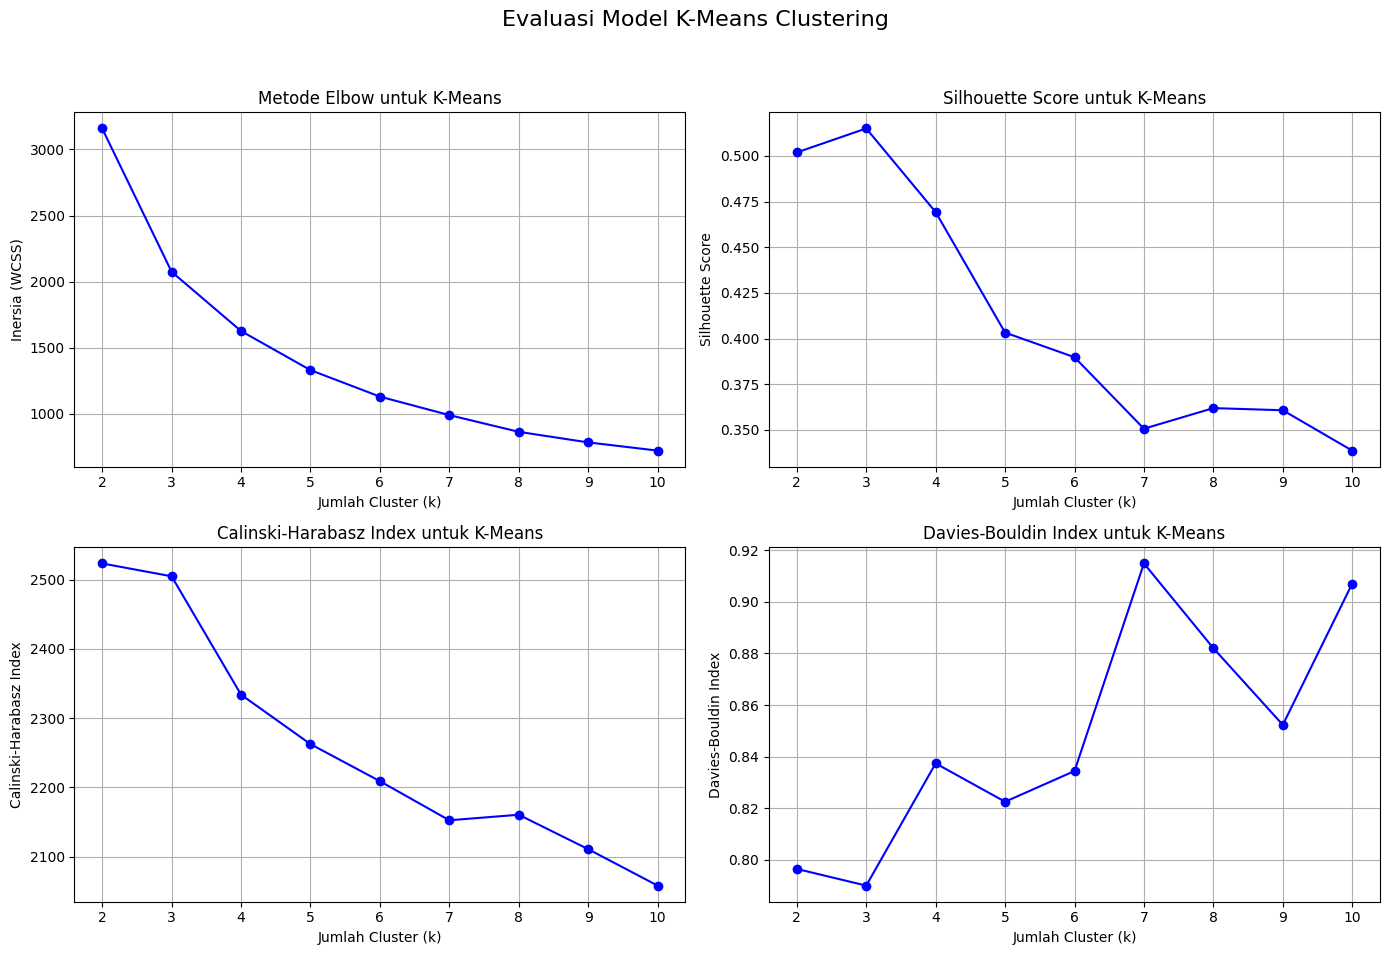

In [29]:
# --- Visualisasi Hasil Evaluasi ---

# Plot untuk K-Means
plt.figure(figsize=(14, 10))
plt.suptitle('Evaluasi Model K-Means Clustering', fontsize=16)

plt.subplot(2, 2, 1)
plt.plot(K, inertia, 'bo-')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Inersia (WCSS)')
plt.title('Metode Elbow untuk K-Means')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(K, silhouette, 'bo-')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score untuk K-Means')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(K, calinski, 'bo-')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Calinski-Harabasz Index')
plt.title('Calinski-Harabasz Index untuk K-Means')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(K, davies, 'bo-')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index untuk K-Means')
plt.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

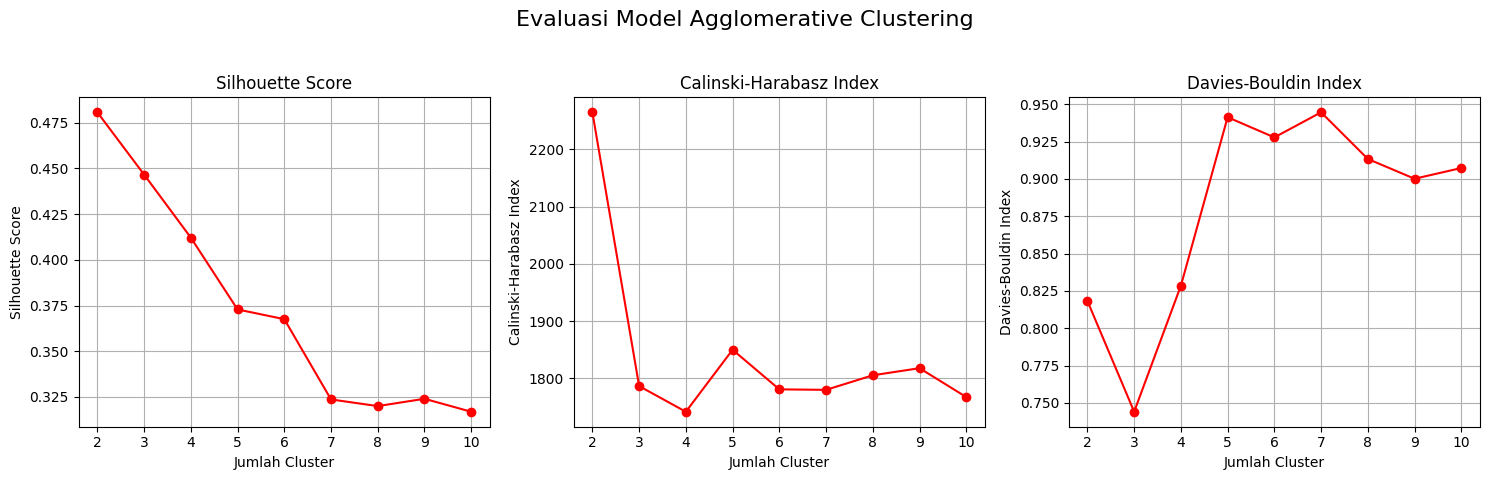

In [30]:
# Plot untuk Agglomerative Clustering
plt.figure(figsize=(15, 5))
plt.suptitle('Evaluasi Model Agglomerative Clustering', fontsize=16)

plt.subplot(1, 3, 1)
plt.plot(K, silhouette_agg, 'ro-')
plt.xlabel('Jumlah Cluster')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(K, calinski_agg, 'ro-')
plt.xlabel('Jumlah Cluster')
plt.ylabel('Calinski-Harabasz Index')
plt.title('Calinski-Harabasz Index')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(K, davies_agg, 'ro-')
plt.xlabel('Jumlah Cluster')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index')
plt.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

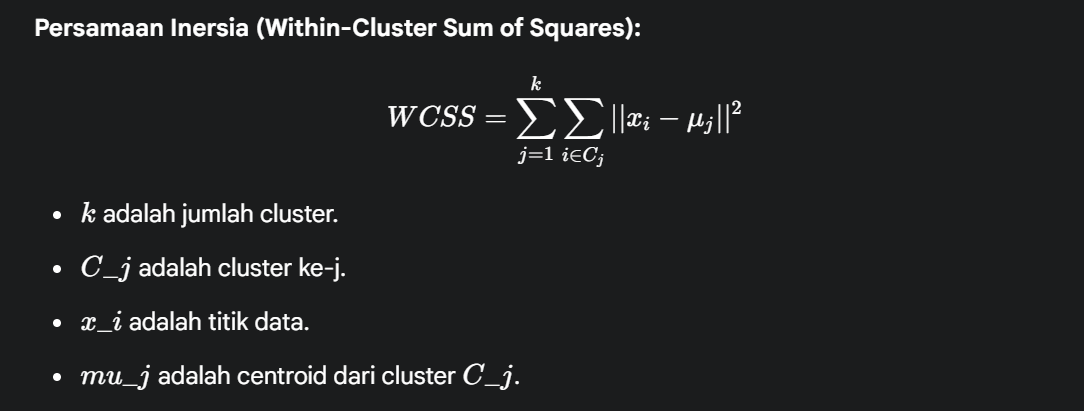

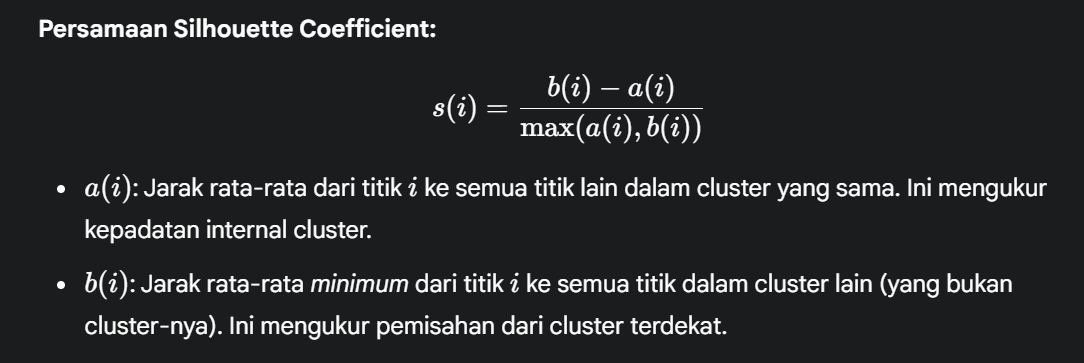

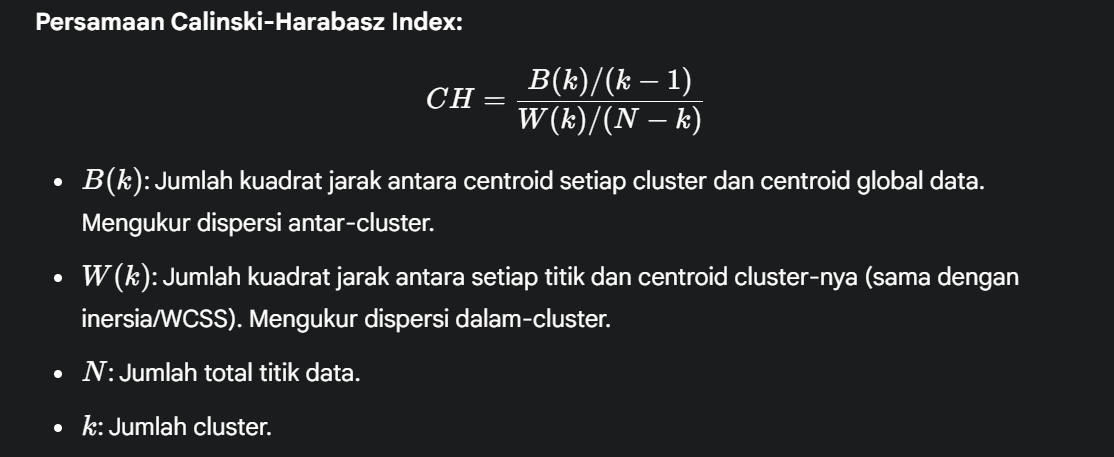

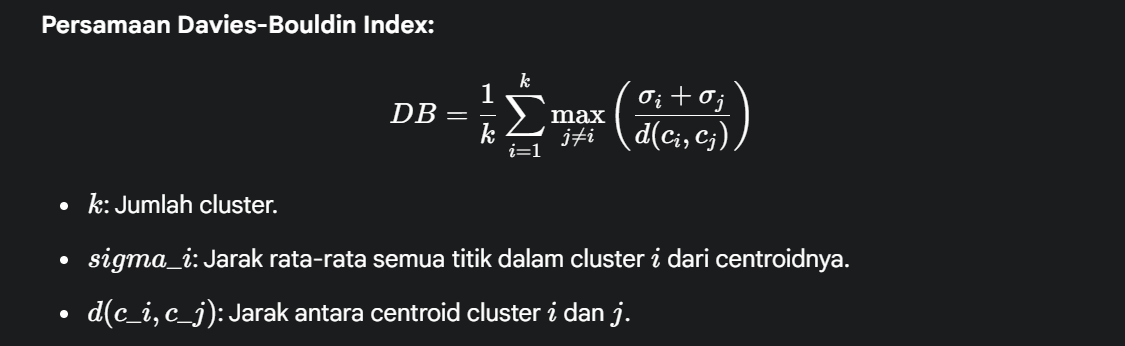

K-Means adalah metode terbaik karena:


*   Secara umum, K-Means mencapai skor puncak yang sedikit lebih baik atau sebanding dengan Agglomerative Clustering.
*   Pilihan jumlah cluster finalnya (k=4) didukung secara logis oleh beberapa metrik evaluasi (Metode Elbow dan Davies-Bouldin), menjadikannya pilihan yang paling seimbang dan dapat dipertahankan.